## Import packages and set seed

- It is highly probable that the folder "auxiliary_scripts" will change its name in the future.
- If this happens then it would be converted into a package called "wavesuite_auxiliary_scripts" and it would have to be installed and imported

In [1]:
import sys

sys.path.insert(0, '../../auxiliary_scripts/')

test_number = 1    #1 or 2

In [2]:
import numpy as np
import vtktools
import matplotlib.pyplot as plt 

import time 

import torch
import torch.nn as nn 

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [3]:
if test_number == 1:
    from test1_just_model3AE import model3_variant1 ,  model3_variant2 ,  model3_variant3 , model3_variant4
    from test1_just_model3AE import model3_variant5 ,  model3_variant6 ,  model3_variant7 , model3_variant8
elif test_number == 2:
    from test2_just_model3AE import model3_variant1 ,  model3_variant2 ,  model3_variant3 , model3_variant4
    from test2_just_model3AE import model3_variant5 ,  model3_variant6 ,  model3_variant7 , model3_variant8

In [4]:
from train_AE_functions import set_seed , train_AE_epoch, validate_AE_epoch , model_MSE_error

from graph_functions import get_node_features, get_complete_edge_list , create_graph_data_list_mnist
from plot_results_mnist import evaluate_and_plot_mnist , compare_four_plots_models_mnist 

from rank_models import plot_losses , rank_losses

In [5]:
from livelossplot import PlotLosses 

set_seed(42)

True

## Create the list of Data objects where each element is a graph

In [6]:
graph_data_list_mnist , n_points = create_graph_data_list_mnist(num_samples_to_use=1000, mnist_path="../../../Datasets/")

In [7]:
graph_data_list_mnist[0]

Data(x=[784, 1], edge_index=[2, 2970])

## Shuffle graph_data_list before splitting

In [8]:
#Compute the number of graphs
n_graphs = len(graph_data_list_mnist)

#Compute one random permutation
permutation0 = np.random.permutation(n_graphs)

In [9]:
shuffle = True

if shuffle:
    #Reorganize graph_data_list taking into account the previous random permutation
    input_graph_data_list = [graph_data_list_mnist[entry] for entry in permutation0]
else: 
    input_graph_data_list = graph_data_list_mnist

## Create DataLoaders

In [10]:
n_graphs = len(input_graph_data_list)

graph_data_list_train = input_graph_data_list[:int(n_graphs * 0.8)]
graph_data_list_validation = input_graph_data_list[int(n_graphs * 0.8):int(n_graphs * 0.9)]
graph_data_list_test = input_graph_data_list[int(n_graphs * 0.9):]

print(len(graph_data_list_train))
print(len(graph_data_list_validation))
print(len(graph_data_list_test))

800
100
100


In [11]:
NUM_GRAPHS_PER_BATCH = 32

train_loader = DataLoader(graph_data_list_train, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
validation_loader = DataLoader(graph_data_list_validation, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(graph_data_list_test, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

## Copy train_AE frunction but modify the available model3_variants

In [12]:
def train_AE(train_loader, validation_loader, 
             num_nodes, num_features, embedding_sequence, latent_space_dim,
             ae_model_type='classic_AE', num_epochs=50, plot_losses=True, 
             seed=42, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ,
             use_sgd_instead_of_adam=False, lr=1e-1, momentum=0.2):
    
    set_seed(seed)
    
    invalid_entry = False
    
    if ae_model_type=='model3_variant1':
        model = model3_variant1(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant2':
        model = model3_variant2(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant3':
        model = model3_variant3(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant4':
        model = model3_variant4(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant5':
        model = model3_variant5(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant6':
        model = model3_variant6(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant7':
        model = model3_variant7(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant8':
        model = model3_variant8(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    else:
        invalid_entry = True
        print('\n An invalid ae_model_type was provided, a classic AE was used as default')
        # model = classic_AE(num_nodes, num_features, latent_space_dim).to(device)
    
    ## The ADAM is the default, since the ADAM optimizer performs better in this case compared against SGD  
    optimizer = torch.optim.Adam(model.parameters())
    if use_sgd_instead_of_adam:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    ## The loss here is the mean_squared_error because the model is an AE
    criterion = nn.MSELoss()
    
    if plot_losses:
        liveloss = PlotLosses()
    loss_register = []
    
    for epoch in range(num_epochs):
        #During each epoch update the parameters
        train_temp_loss = train_AE_epoch(model, optimizer, criterion, train_loader, device, num_nodes)
        
        #Optional: Check the validation loss in each epoch
        validation_temp_loss = validate_AE_epoch(model, criterion, validation_loader, device, num_nodes) 
        
        #Compute the losses in each iteration 
        logs = {}
        logs['' + 'log loss'] = train_temp_loss.item()
        logs['val_' + 'log loss'] = validation_temp_loss.item()
        loss_register.append(logs)
        
        #Optionally plot the train and validation loss   
        if plot_losses:
            liveloss.update(logs)
            liveloss.draw()
            
    if invalid_entry == True:
        print('\n An invalid ae_model_type was provided, a classic AE was used as default') 
        
    print("\n Number of parameters: ", sum(p.numel() for p in model.parameters()))
    
    #At the end just return 1. the model with the trained parameters and 2. the list of losses in every epoch
    return model, loss_register   


## Let's train some models

In [13]:
#This dictionary stores the losses results of the models
results_variants = {}

In [14]:
#These are the models specifications
num_features = 1  #This is always 1
embedding_sequence = [8, 16, 2, 2, 16, 8] 
latent_space_dim = 32
num_epochs = 80   

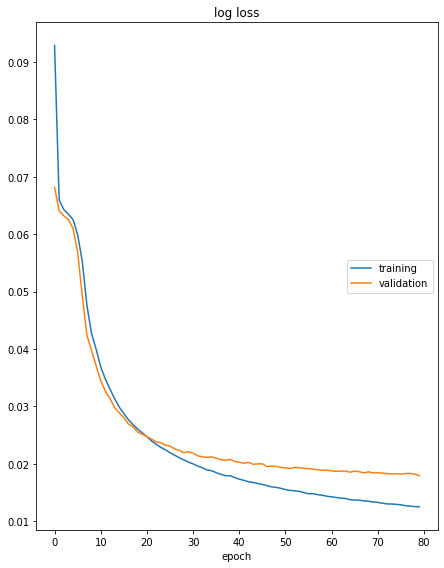

log loss
	training         	 (min:    0.013, max:    0.093, cur:    0.013)
	validation       	 (min:    0.018, max:    0.068, cur:    0.018)

 Number of parameters:  206915
Time taken:  46.06652212142944


In [15]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant1'

variant1, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant1', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

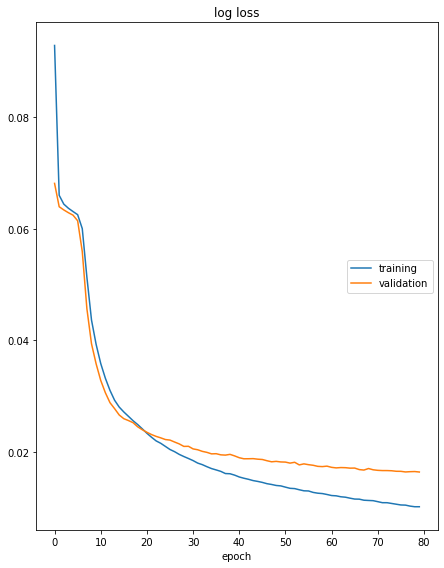

log loss
	training         	 (min:    0.010, max:    0.093, cur:    0.010)
	validation       	 (min:    0.016, max:    0.068, cur:    0.016)

 Number of parameters:  206915
Time taken:  44.1870334148407


In [16]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant2'

variant2, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant2', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

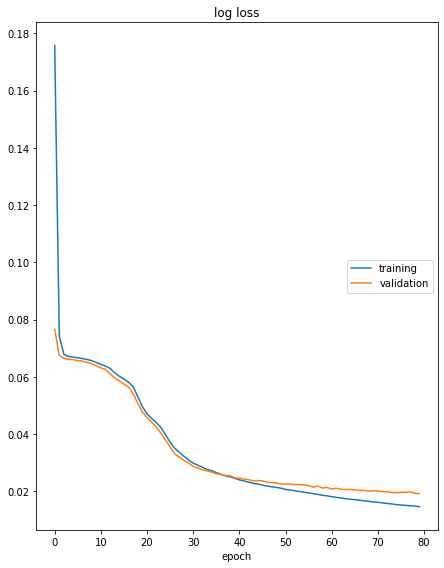

log loss
	training         	 (min:    0.015, max:    0.176, cur:    0.015)
	validation       	 (min:    0.019, max:    0.077, cur:    0.019)

 Number of parameters:  206915
Time taken:  44.08146953582764


In [17]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant3'

variant3, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant3', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

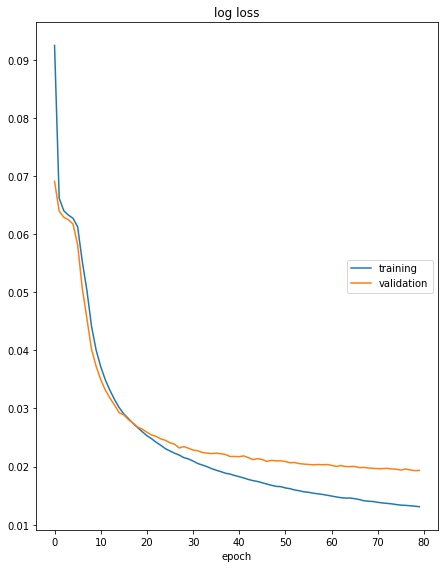

log loss
	training         	 (min:    0.013, max:    0.092, cur:    0.013)
	validation       	 (min:    0.019, max:    0.069, cur:    0.019)

 Number of parameters:  206915
Time taken:  44.27230501174927


In [18]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant4'

variant4, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant4', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

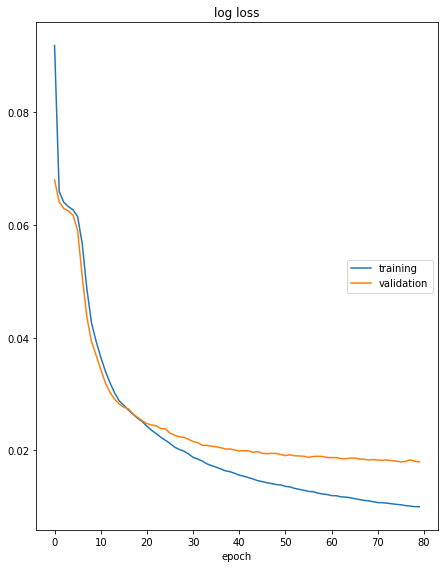

log loss
	training         	 (min:    0.010, max:    0.092, cur:    0.010)
	validation       	 (min:    0.018, max:    0.068, cur:    0.018)

 Number of parameters:  206915
Time taken:  44.30887007713318


In [19]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant5'

variant5, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant5', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

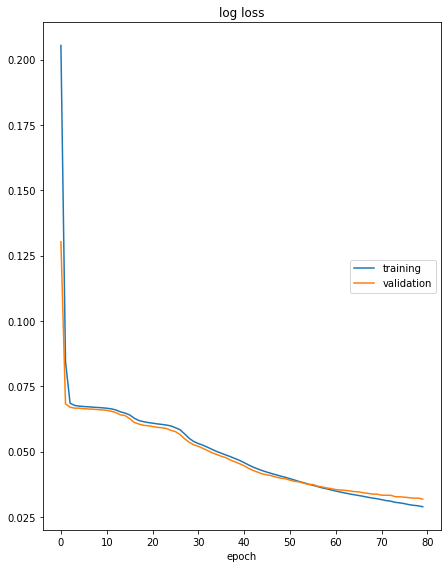

log loss
	training         	 (min:    0.029, max:    0.205, cur:    0.029)
	validation       	 (min:    0.032, max:    0.130, cur:    0.032)

 Number of parameters:  206915
Time taken:  44.20837616920471


In [20]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant6'

variant6, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant6', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

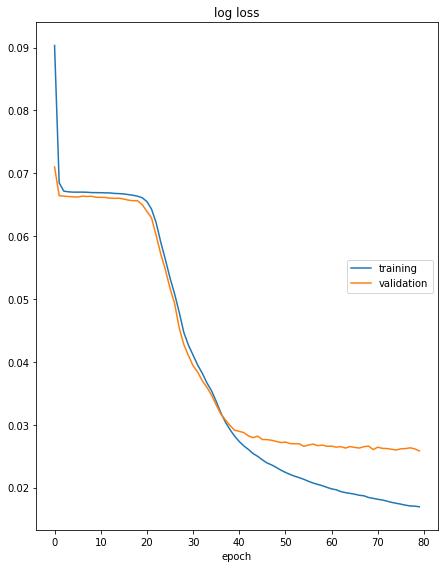

log loss
	training         	 (min:    0.017, max:    0.090, cur:    0.017)
	validation       	 (min:    0.026, max:    0.071, cur:    0.026)

 Number of parameters:  206915
Time taken:  44.081308364868164


In [21]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant7'

variant7, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant7', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

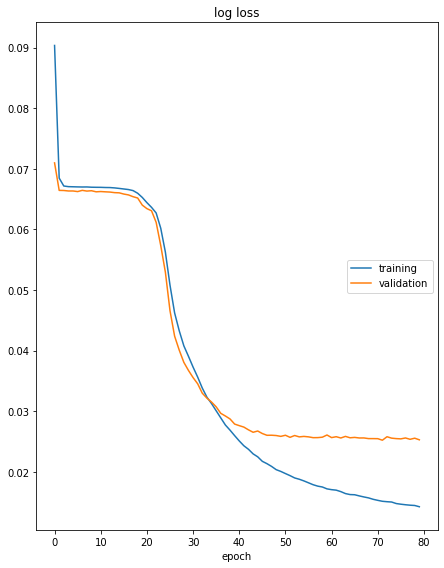

log loss
	training         	 (min:    0.014, max:    0.090, cur:    0.014)
	validation       	 (min:    0.025, max:    0.071, cur:    0.025)

 Number of parameters:  206915
Time taken:  44.03250455856323


In [22]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant8'

variant8, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant8', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

## MSE results

In [23]:
variants_names = list( results_variants.keys() )

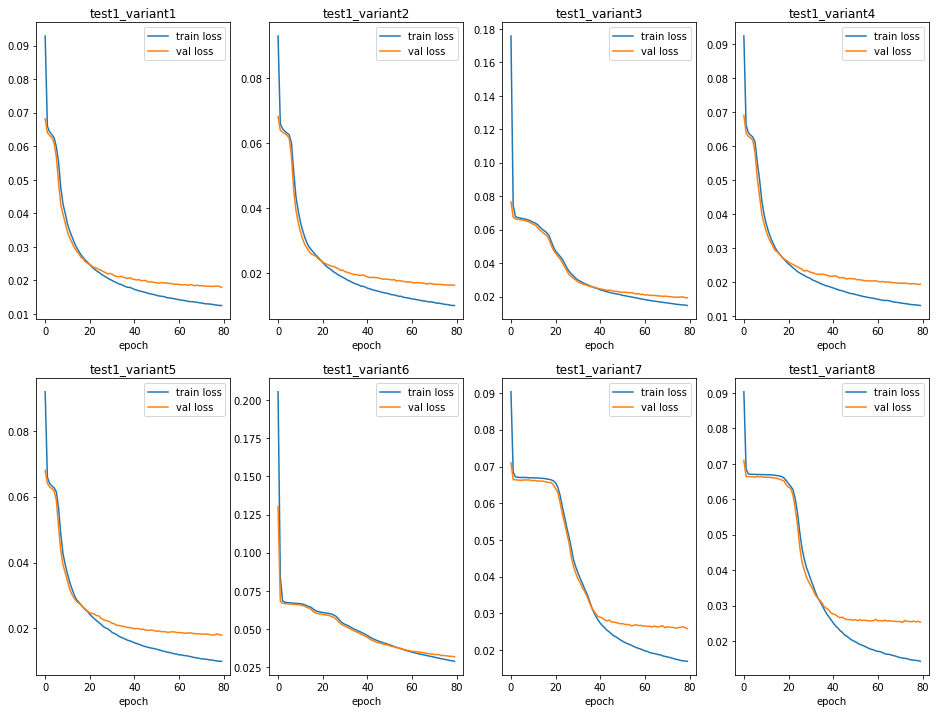

In [24]:
filename = 'model3_mnist_test'+str(test_number)+'_variants_losses.png'
plot_losses(results_variants, variants_names, filename=filename, figsize=(16,12))

In [25]:
rank_losses(results_variants, variants_names, selected_epoch = int(num_epochs/4) )

,variants_name,final_validation_loss
0,test1_variant2,0.023970
1,test1_variant1,0.025153
2,test1_variant5,0.025255
3,test1_variant4,0.026424
4,test1_variant3,0.047753
5,test1_variant6,0.059916
6,test1_variant8,0.064007
7,test1_variant7,0.065004


In [26]:
rank_losses(results_variants, variants_names, selected_epoch = int(num_epochs/2) )

,variants_name,final_validation_loss
0,test1_variant2,0.019277
1,test1_variant5,0.020091
2,test1_variant1,0.020428
3,test1_variant4,0.021742
4,test1_variant3,0.024732
5,test1_variant8,0.027888
6,test1_variant7,0.029141
7,test1_variant6,0.045398


In [27]:
first_column_model_name = 'Model3'
filename = 'model3_mnist_test'+str(test_number)+'_variants_losses.csv'

df_losses = rank_losses(results_variants, variants_names, selected_epoch = num_epochs,
                       first_column_model_name = first_column_model_name, filename = filename )

df_losses

CSV was saved


,Model name,variants_name,final_validation_loss
0,Model3,test1_variant2,0.016390
1,Model3,test1_variant1,0.017954
2,Model3,test1_variant5,0.017962
3,Model3,test1_variant3,0.019246
4,Model3,test1_variant4,0.019342
5,Model3,test1_variant8,0.025293
6,Model3,test1_variant7,0.025853
7,Model3,test1_variant6,0.031847


The difference between the first five model losses are negiglible.

Also: 

- In MNIST, VARIANTS 1,4 and 7 show that having an output activation function is important or else we get the dirty background
- In air pollution data (the other notebook) VARIANT 8 does not converge

Therefore, I am going to choose variant3 for model3.

In [28]:
#print( 'model3_variant1 error: ', model_MSE_error(variant1, train_loader) )
#print( 'model3_variant2 error: ', model_MSE_error(variant2, train_loader) )
#print( 'model3_variant3 error: ', model_MSE_error(variant3, train_loader) )
#print( 'model3_variant4 error: ', model_MSE_error(variant4, train_loader) )
#print( 'model3_variant5 error: ', model_MSE_error(variant5, train_loader) )
#print( 'model3_variant6 error: ', model_MSE_error(variant6, train_loader) )
#print( 'model3_variant7 error: ', model_MSE_error(variant7, train_loader) )
#print( 'model3_variant8 error: ', model_MSE_error(variant8, train_loader) )

# Plot the results

Indexes plotted [51 92 14]


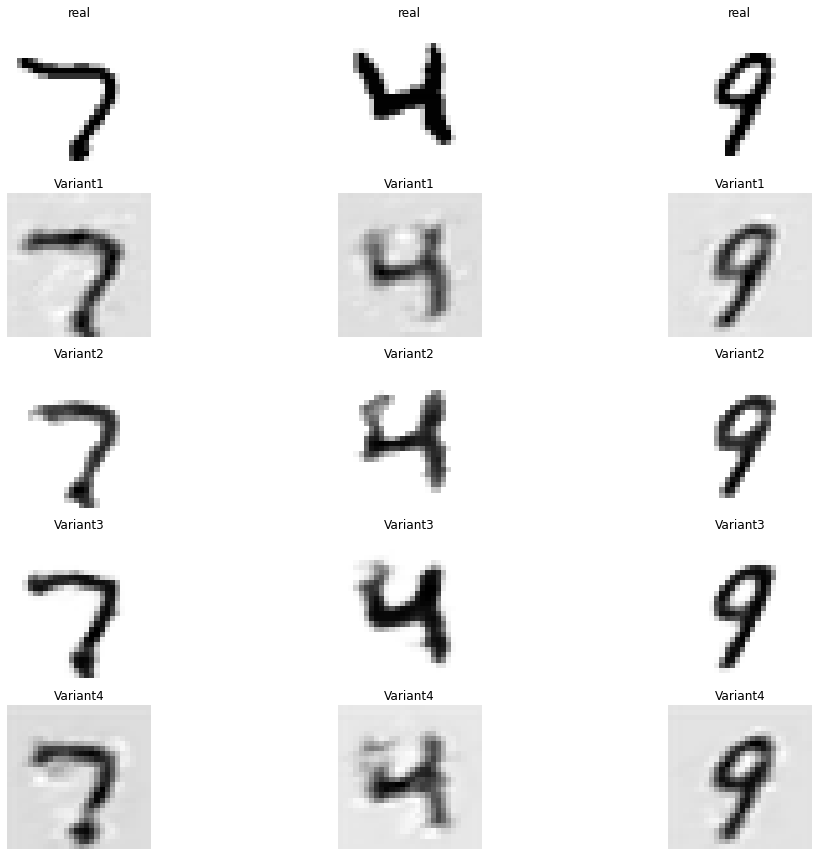

In [29]:
compare_four_plots_models_mnist(variant1, variant2, variant3, variant4, 
                               graph_data_list_test, nDisplay=3, axis_off=True, 
                               random=True, batch_size=32,
                               save_fig=True, filename='mnist_model3_test'+str(test_number)+'_variants_1to4.png',
                                 set_pred_labels_as = ["Variant1", "Variant2", "Variant3", "Variant4"]  )

Indexes plotted [2, 50, 90]


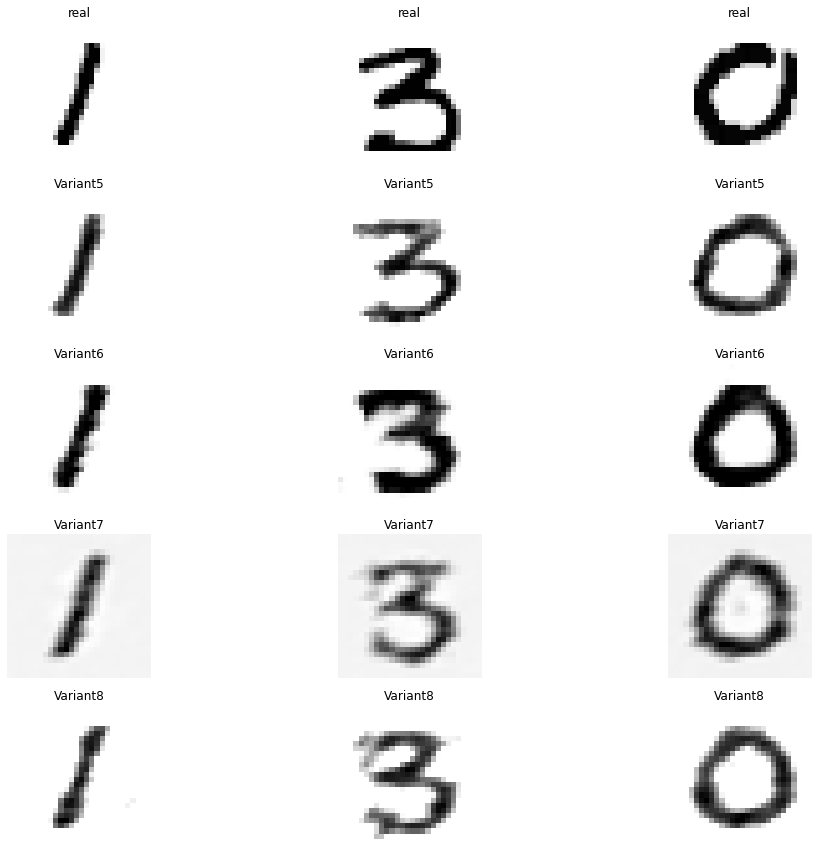

In [30]:
compare_four_plots_models_mnist(variant5, variant6, variant7, variant8, 
                               graph_data_list_test, nDisplay=3, axis_off=True, 
                               random=False, index_sequence=[2, 50, 90] , batch_size=32,
                               save_fig=True, filename='mnist_model3_test'+str(test_number)+'_variants_5to8.png',
                                 set_pred_labels_as = ["Variant5", "Variant6", "Variant7", "Variant8"]  )

Lets plot the top 3 variants obtained

Indexes plotted [71 60 20 82 86 74 74 87]


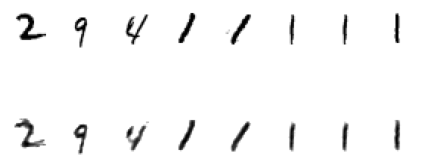

In [31]:
evaluate_and_plot_mnist(variant2, test_loader, 8)

Indexes plotted [99 23  2 21 52  1 87 29]


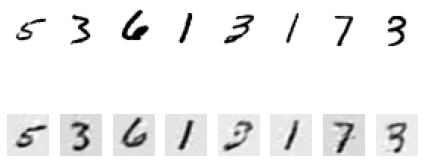

In [32]:
evaluate_and_plot_mnist(variant1, test_loader, 8)

Indexes plotted [37  1 63 59 20 32 75 57]


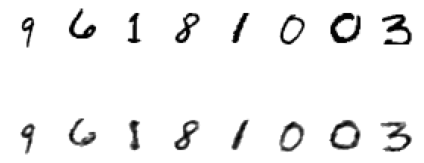

In [33]:
evaluate_and_plot_mnist(variant5, test_loader, 8)

Also, since variant3 performs the best for the air_pollution dataset, lets plot that vartiant too

Indexes plotted [21 88 48 90 58 41 91 59]


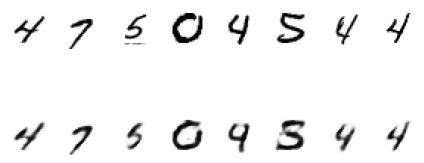

In [34]:
evaluate_and_plot_mnist(variant3, test_loader, 8)